# Climate Analysis

In [1]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine,inspect,func

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import datetime as date

In [3]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [4]:
# Declare a Base using `automap_base()`
# reflect an existing database into a new model
Base = automap_base()
# reflect the database tables
Base.prepare(engine, reflect=True)

In [8]:
#store tables
Measurement = Base.classes.measurements
Station = Base.classes.stations

In [9]:
# Create a session
session = Session(engine)

# Exploring the database

In [10]:
# Getting the table names for each table
inspector = inspect(engine)
inspector.get_table_names()

['measurements', 'stations']

In [11]:
# Get a list of column names and types - measurements
columns = inspector.get_columns('Measurements')
for col in columns:
    print(col['name'], col["type"])

meas_id INTEGER
station VARCHAR(255)
date DATE
prcp FLOAT
tobs FLOAT


In [12]:
# Get a list of column names and types - stations
columns = inspector.get_columns('stations')
for col in columns:
    print(col['name'], col["type"])

id INTEGER
station VARCHAR(255)
name VARCHAR(255)
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
engine.execute('SELECT * FROM stations LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [22]:
engine.execute('SELECT * FROM measurements LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

## Precipitation Analysis

* Design a query to retrieve the last 12 months of precipitation data.

* Select only the `date` and `prcp` values.

* Load the query results into a Pandas DataFrame and set the index to the date column.

* Plot the results using the DataFrame `plot` method.

* Use Pandas to print the summary statistics for the precipitation data.


In [27]:
# Grabs the last date entry in the data table
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)

(datetime.date(2017, 8, 23),)


In [28]:
# to get the last 12 months of data, last date - 365
last_year = date.date(2017, 8, 23) - date.timedelta(days=365)
print(last_year)

2016-08-23


In [30]:
# query to pull the last year of precipitation data
rain = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > last_year).\
    order_by(Measurement.date).all()

In [31]:
# Load the data from the query into a dataframe

rain_df = pd.DataFrame(rain)
rain_df.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


In [32]:
#reset the index to the date
rain_df.set_index('date').head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


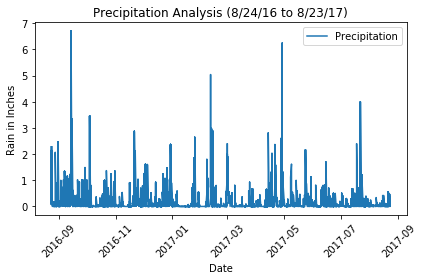

In [33]:
# plot the dataframe
rain_df.plot('date', 'prcp')
plt.xlabel("Date")
plt.ylabel("Rain in Inches")
plt.title("Precipitation Analysis (8/24/16 to 8/23/17)")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [34]:
# Use Pandas to print the summary statistics for the precipitation data.
rain_df.describe()

,prcp
count,6045.000000
mean,0.176462
std,0.460212
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis
* Design a query to calculate the total number of stations.
* Design a query to find the most active stations.
* List the stations and observation counts in descending order
* Which station has the highest number of observations?
* Design a query to retrieve the last 12 months of temperature observation data (tobs).
* Filter by the station with the highest number of observations.
* Plot the results as a histogram with bins=12.

In [37]:
# Count the number of stations in the Measurement table
locations = session.query(Measurement).group_by(Measurement.station).count()
print("There are {} stations.".format(locations))

There are 9 stations.


In [40]:
# find the station with the most temperature observations, then list them all in descending order
busy_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
               order_by(func.count(Measurement.tobs).desc()).all()

busiest = busy_station[0][0]    
print("The busiest Station was",busiest,"with",busy_station[0][1],"weather observations.")
print()
print("Here are all of the Stations (in descending order) with their number of observations:")
for station, count in busy_station:
    print("Station",station,"had",count, "weather observations.")

The busiest Station was USC00519281 with 8316 weather observations.

Here are all of the Stations (in descending order) with their number of observations:
Station USC00519281 had 8316 weather observations.
Station USC00519397 had 8172 weather observations.
Station USC00513117 had 8127 weather observations.
Station USC00519523 had 8007 weather observations.
Station USC00516128 had 7836 weather observations.
Station USC00514830 had 6606 weather observations.
Station USC00511918 had 5937 weather observations.
Station USC00517948 had 4116 weather observations.
Station USC00518838 had 1533 weather observations.


In [42]:
# query to pull the last year of precipitation data for the busiest station
temperature = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == busiest).\
    filter(Measurement.date > last_year).\
    order_by(Measurement.date).all()

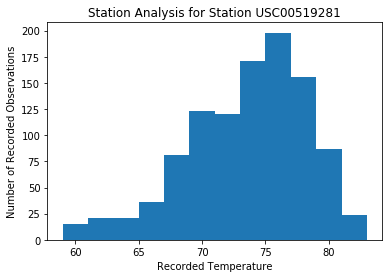

In [53]:
# plot the temperature data in a histogram with 12 bins
temp_df=pd.DataFrame(temperature)
plt.hist(temp_df['tobs'],12)
plt.xlabel("Recorded Temperature")
plt.ylabel("Number of Recorded Observations")
plt.title("Station Analysis for Station " + busiest)
plt.show()

## Temperature Analysis
* Write a function called calc_temps that will accept a start date and end date in the format %Y-%m-%d and return the 
  minimum, average, and maximum temperatures for that range of dates.
* Use the calc_temps function to calculate the min, avg, and max temperatures for your trip using the matching dates 
  from the previous year (i.e. use "2017-01-01" if your trip start date was "2018-01-01")
* Plot the min, avg, and max temperature from your previous query as a bar chart.
- Use the average temperature as the bar height.
- Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).

In [48]:
def calc_temps(start_date, end_date):
    #create dates 1 year prior
    dates = [start_date, end_date]
    new_dates = []
    for date in dates:
        date_list = date.split("-")
        date_list[0] = str(int(date_list[0]) - 1)
        new_date = "-".join(date_list)
        new_dates.append(new_date)
    print(new_dates) 
    
    #query database for temps from those dates
    temp_values = session.query(Measurement.tobs).filter(Measurement.date >= new_dates[0], Measurement.date <= new_dates[1]).all()
    temp_values_list = [x for (x,) in temp_values]
    avg_temp = np.mean(temp_values_list)
    max_temp = max(temp_values_list)
    min_temp = min(temp_values_list)
    
    # create bar graph
    plt.figure(figsize=(2,5))
    plt.title("Trip Average Temp")
    plt.ylabel("Temperature (F)")
    plt.bar(1, avg_temp, yerr = (max_temp - min_temp), tick_label = "")
    plt.show()

['2017-08-01', '2017-08-14']


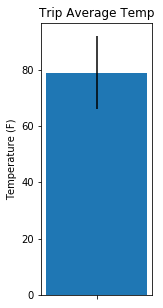

In [49]:
calc_temps('2018-08-01', '2018-08-14')

## Daily Normals

In [51]:
#query to return list of temps for each date
def daily_normals(chosen_date):
    temps = session.query(Measurement.tobs).filter(Measurement.date.like('%'+chosen_date)).all()
    obs = [x for (x), in temps]
    return obs
    
start_date = '08-23'
end_date = '09-04'

#function to generate list of dates given any start and end date
def create_date_list(start_date, end_date):
    start_month = start_date.split("-")[0]
    end_month = end_date.split("-")[0]
    
    start_day = int(start_date.split("-")[1])
    end_day = int(end_date.split("-")[1])
    
    if start_month == end_month:
        diff = end_day - start_day
        days = [start_day + x for x in range(0,diff + 1) ]
    
    else:
        diff1 = 31 - start_day
        days1 = [start_day + x for x in range(0,diff1 + 1)]
        days2 = [x for x in range(1, end_day + 1)]
        days = days1 + days2
        
    days_str = [('%s-%s' % (start_month, str(x))) if len(str(x)) == 2 else ('%s-0%s' % (end_month, str(x))) for x in days]
    return days_str

#uses functions above to return dictionary of normals, skips dates for which there is no data (false dates)
def query_results(start, end):
    dates = create_date_list(start, end)
    master_dict = {"Date": [], "Max Temp": [], "Min Temp": [], "Average Temp": []}
    for date in dates:
        data_list = []
        observations = daily_normals(date)
        if observations != []:
            for temp in observations:
                data_list.append(temp)
            master_dict['Date'].append(date)
            master_dict['Max Temp'].append(max(data_list))
            master_dict['Min Temp'].append(min(data_list))
            master_dict['Average Temp'].append(round(np.mean(data_list),2))
            master_dict
    return(master_dict)
    
normals_df = pd.DataFrame(query_results('08-01', '08-14')).set_index('Date')
normals_df

,Average Temp,Max Temp,Min Temp
Date,,,
08-01,75.54,83.0,67.0
08-02,75.60,84.0,68.0
08-03,76.61,85.0,70.0
08-04,76.71,84.0,69.0
08-05,76.15,82.0,69.0
08-06,76.25,83.0,67.0
08-07,77.16,83.0,71.0
08-08,76.56,83.0,68.0
08-09,75.98,81.0,69.0


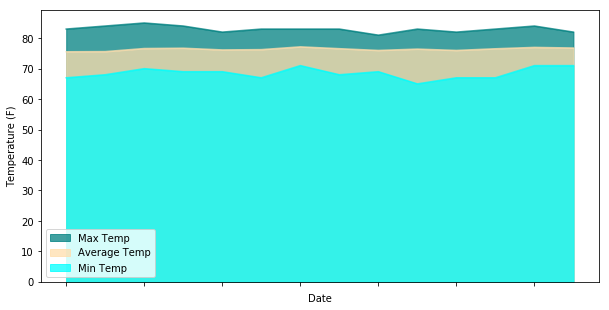

In [52]:
normals_df = normals_df[['Max Temp', 'Average Temp', 'Min Temp']]

normals_df.plot(kind = 'area', stacked = False, alpha = .75, rot = 45, color = ['teal', 'navajowhite', 'aqua'], figsize = (10,5), linestyle = 'solid')
plt.xlabel('Date')
plt.ylabel('Temperature (F)')
plt.legend(frameon = True)
plt.show()